In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio

from scipy.optimize import nnls

In [2]:
n_qsos = 130000
with fitsio.FITS("data/qsos_noisy.fits", "r") as h:
    flux_noisy = h["FLUX"][:, n_qsos:(n_qsos + 10000)]
    ivar = h["IVAR"][:, n_qsos:(n_qsos + 10000)]
    w_grid = h["WAVELENGTH"].read()
    z = h["Z"][n_qsos:(n_qsos + 10000)]

In [3]:
# This is what we actually plot, and we scale the fits to
# match which
with fitsio.FITS("data/qsos_no_renorm_noisy.fits", "r") as h:
    flux_renorm = h["FLUX"][:, n_qsos:(n_qsos + 10000)]

In [4]:
rng = np.random.default_rng(1009921)

In [5]:
# Low Redshift
idx_1 = np.where(z < 0.1)
choice_1 = rng.choice(idx_1, size=1, replace=False, axis=1)[0]

f_choice_1 = flux_renorm[:, choice_1] * (ivar[:, choice_1] != 0)
f_choice_1[f_choice_1 == 0] = np.nan

f_noisy_1 = flux_noisy[:, choice_1] * (ivar[:, choice_1] != 0)
f_noisy_1[f_noisy_1 == 0] = np.nan

# Intermediary Redshift
idx_2 = np.where((z >= 1.4) & (z < 2.1))
choice_2 = rng.choice(idx_2, size=1, replace=False, axis=1)[0]
f_choice_2 = flux_renorm[:, choice_2] * (ivar[:, choice_2] != 0)
f_choice_2[f_choice_2 == 0] = np.nan

f_noisy_2 = flux_noisy[:, choice_2] * (ivar[:, choice_2] != 0)
f_noisy_2[f_noisy_2 == 0] = np.nan

# High Redshift
idx_3 = np.where((z >= 3.2))
choice_3 = rng.choice(idx_3, size=1, replace=False, axis=1)[0]
f_choice_3 = flux_renorm[:, choice_3] * (ivar[:, choice_3] != 0)
f_choice_3[f_choice_3 == 0] = np.nan

f_noisy_3 = flux_noisy[:, choice_3] * (ivar[:, choice_3] != 0)
f_noisy_3[f_noisy_3 == 0] = np.nan

In [6]:
# This from the output of the training script but could be
# found by loading the data and replicating the same process
# from that script
keep_range = np.s_[50:11100]

In [7]:
noisy = [f_noisy_1, f_noisy_2, f_noisy_3]
renorm = [f_choice_1, f_choice_2, f_choice_3]
redshifts = [z[choice_1][0], z[choice_2][0], z[choice_3][0]]
choices = [choice_1[0], choice_2[0], choice_3[0]]


In [8]:
X = flux_noisy
V = ivar

V_X = np.sqrt(V) * X

In [9]:
# Fit the noisy templates to the given three spectra
W_noisy = np.load("templates/W_nearly_noisy.npy")

recons_noisy = []
chi_2_noisy = []
for i in choices:
    V_diag = np.diag(V[keep_range, i])
    W = np.sqrt(V_diag) @ W_noisy
    H_0, _ = nnls(W, V_X[keep_range, i])
    recon = W_noisy @ H_0
    recons_noisy.append(recon)

    chi_2 = np.sum(V[keep_range, i] * (X[keep_range, i] - recon) ** 2)
    print(chi_2)
    chi_2_noisy.append(chi_2)

3990.6842495514525
4536.8757961920655
4546.489730998844


In [10]:
# Fit the noiseless templates to the given three spectra
W_noiseless = np.load("templates/W_nearly_noiseless.npy")

recons_noiseless = []
chi_2_noiseless = []
for i in choices:
    V_diag = np.diag(V[keep_range, i])
    W = np.sqrt(V_diag) @ W_noiseless
    H_0, _ = nnls(W, V_X[keep_range, i])
    recon = W_noiseless @ H_0
    recons_noiseless.append(recon)

    chi_2 = np.sum(V[keep_range, i] * (X[keep_range, i] - recon) ** 2)
    print(chi_2)
    chi_2_noiseless.append(chi_2)

3991.257178269927
4644.490263254675
4543.151957593233


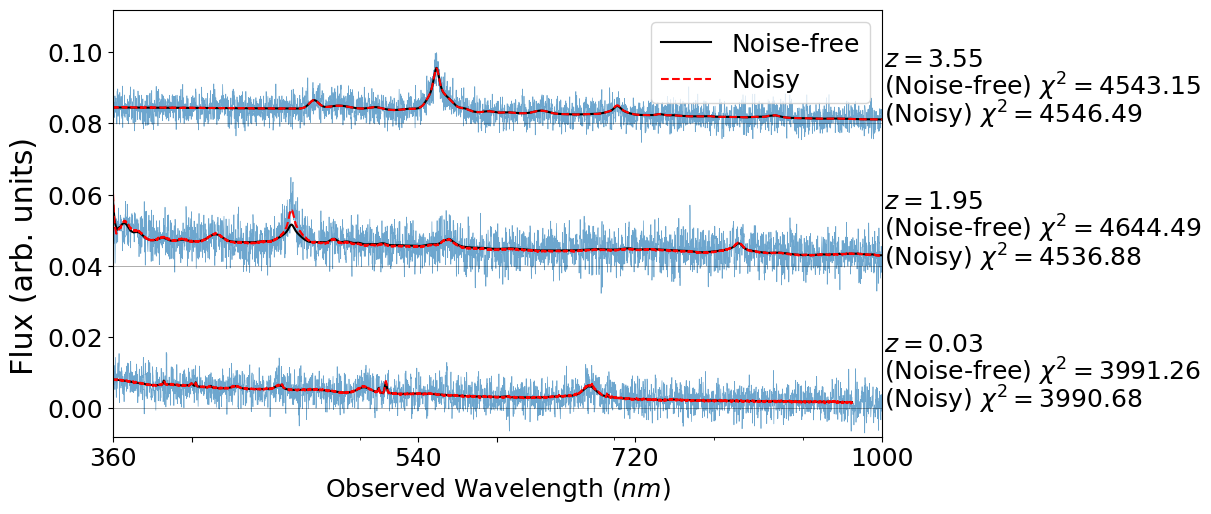

In [11]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1, 1, figsize=(12, 5), layout="constrained")

scale_factor = 250
offset = 10 / scale_factor
text_offset = 2 / scale_factor
scale_range = (w_grid > 3600) & (w_grid < 10000)
for i in range(len(noisy)):
    
    ax.plot(w_grid * (1 + redshifts[i]), renorm[i] + offset * i, c="C0", lw=0.5, alpha=0.65)
    ylim = ax.get_ylim() # Want to set the ylims by the original spectra not the reconstruction
    
    scale = np.nanmedian(renorm[i]) / np.nanmedian(noisy[i])
    label = "Noise-free" if i == 0 else None
    ax.plot(w_grid[keep_range] * (1 + redshifts[i]), recons_noiseless[i] * scale + offset * i, c="k", lw=1.5, label=label)
    label = "Noisy" if i == 0 else None
    ax.plot(w_grid[keep_range] * (1 + redshifts[i]), recons_noisy[i] * scale + offset * i, c="red", ls="dashed", lw=1.5, label=label)

    # Annotating their redshifts
    this_z = str(np.round(redshifts[i], decimals=2))
    ax.text(10000 + 20, text_offset * 2 + i * offset, f"$z=${this_z}", ha="left")
    noiseless_chi = np.round(chi_2_noiseless[i], decimals=2)
    noisy_chi = np.round(chi_2_noisy[i], decimals=2)
    ax.text(10000 + 20, text_offset * 1 + i * offset, f"(Noise-free) $\chi^2={noiseless_chi}$", ha="left")
    ax.text(10000 + 20, i * offset,   f"(Noisy) $\chi^2={noisy_chi}$ ", ha="left")

    ax.axhline(y=offset * i, alpha=0.45, c="k", lw=0.5)

ax.set(xscale="log",  xlim=(3600, 10000), ylim=(-2 / scale_factor, 28 / scale_factor))

# Last two clear the ones already there.
x_labels = np.asarray([360, 540, 720, 1000, 400, 600])
ax.set_xticks(x_labels*10, np.hstack([x_labels[:-2], ["", ""]]))
ax.legend(loc="upper right")
    
fig.supylabel("Flux (arb. units)")
plt.xlabel("Observed Wavelength ($nm$)")
plt.savefig("plots/qso_recons.pdf", bbox_inches="tight", dpi=256)